# Ambulance Station to Hospital Travel Time Analysis

This notebook builds a directed bipartite graph connecting ambulance stations to acute hospitals using LSOA-level travel times and fallback estimates. It generates analytics, visualisations, and export artifacts.

In [1]:
# Setup: install and import packages
import sys, subprocess, pkgutil, warnings
warnings.filterwarnings('ignore')

def ensure_pkg(pkg):
    if pkgutil.find_loader(pkg) is None:
        subprocess.run([sys.executable, '-m', 'pip', '-q', 'install', pkg])

packages = ['pandas','numpy','networkx','folium','matplotlib','scikit-learn','pyproj','shapely']
for p in packages:
    ensure_pkg(p)

try:
    ensure_pkg('torch')
    import torch
    TORCH_AVAILABLE = True
except Exception as e:
    TORCH_AVAILABLE = False
    print('Torch not available:', e)

import pandas as pd
import numpy as np
import networkx as nx
import folium
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.st

In [2]:
DATA_DIR = Path('/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level')

stations = pd.read_csv(DATA_DIR / 'ambulance_stations_icb.csv')
hospitals = pd.read_csv(DATA_DIR / 'acute_hospitals_icb.csv')
matrix = pd.read_csv(DATA_DIR / 'travel_matrix_lsoa_icb.csv')

print('Stations shape:', stations.shape)
print(stations.head())
print('Hospitals shape:', hospitals.shape)
print(hospitals.head())
print('Matrix shape:', matrix.shape)
print(matrix.head())

required_station=['Code','Name','latitude','longitude','lsoa21cd']
required_hospital=['Code','Name','latitude','longitude','lsoa21cd']
required_matrix=['origin_lsoa','dest_lsoa','time_car_min']
for req, df, name in [
        (required_station, stations, 'stations'),
        (required_hospital, hospitals, 'hospitals'),
        (required_matrix, matrix, 'matrix')]:
    missing=[c for c in req if c not in df.columns]
    if missing:
        raise ValueError(f"{name} missing columns: {missing}")

Stations shape: (14, 19)
    Code                         Name               Address 1   Address 2  \
0  RYF62     Bodmin Ambulance Station               Barn Lane         NaN   
1  RYF65       Bude Ambulance Station  16 West Fairholme Road         NaN   
2  RYF64  Camelford Ambulance Station          10 High Street         NaN   
3  RYF26       Cornwall Air Ambulance              St. Mawgan  Hangar 402   
4  RYF58   Falmouth Ambulance Station          Trevaylor Road         NaN   

  Address 3  Address 4 Address 5  Postcode               Type  \
0       NaN     Bodmin  Cornwall  PL31 1LT  Ambulance station   
1       NaN       Bude  Cornwall  EX23 8JD  Ambulance station   
2       NaN  Camelford  Cornwall  PL32 9PQ  Ambulance station   
3       NaN    Newquay  Cornwall   TR8 4HP  Ambulance station   
4       NaN   Falmouth  Cornwall  TR11 2JY  Ambulance station   

  Parent Organisation Code                           Parent Organisation Name  \
0                      QT6  NHS Cornwall

In [3]:
# Clean & Harmonise
stations['lsoa21cd'] = stations['lsoa21cd'].str.strip().str.upper()
hospitals['lsoa21cd'] = hospitals['lsoa21cd'].str.strip().str.upper()

stations = stations.drop_duplicates('Code').dropna(subset=['latitude','longitude','lsoa21cd'])
hospitals = hospitals.drop_duplicates('Code').dropna(subset=['latitude','longitude','lsoa21cd'])

# Fix dataset lat/lon swap and compute BNG coordinates
# Source data has 'latitude' holding longitude (~-4 to -6) and 'longitude' holding latitude (~50).
stations['lon'] = stations['latitude']
stations['lat'] = stations['longitude']
hospitals['lon'] = hospitals['latitude']
hospitals['lat'] = hospitals['longitude']

from pyproj import Transformer
_node_transformer = Transformer.from_crs('EPSG:4326', 'EPSG:27700', always_xy=True)
stations['x_bng'], stations['y_bng'] = _node_transformer.transform(stations['lon'].values, stations['lat'].values)
hospitals['x_bng'], hospitals['y_bng'] = _node_transformer.transform(hospitals['lon'].values, hospitals['lat'].values)

if 'icb_code' in stations.columns and 'icb_code' in hospitals.columns:
    st_icb = set(stations['icb_code'].unique())
    ho_icb = set(hospitals['icb_code'].unique())
    print('Station ICB codes:', st_icb)
    print('Hospital ICB codes:', ho_icb)
    if st_icb != ho_icb:
        print('Warning: station and hospital ICB codes differ.')

Station ICB codes: {'E54000036'}
Hospital ICB codes: {'E54000036'}


In [4]:
# Build Station-Hospital Pair Table
# Use corrected lat/lon columns
station_cols={'Code':'station_code','Name':'station_name','lat':'station_lat','lon':'station_lon','lsoa21cd':'station_lsoa'}
hospital_cols={'Code':'hospital_code','Name':'hospital_name','lat':'hospital_lat','lon':'hospital_lon','lsoa21cd':'hospital_lsoa'}

if 'icb_code' in stations.columns and 'icb_code' in hospitals.columns:
    pairs = stations.rename(columns=station_cols).merge(
        hospitals.rename(columns=hospital_cols),
        on='icb_code', how='outer')
else:
    stations_tmp = stations.rename(columns=station_cols).assign(key=1)
    hospitals_tmp = hospitals.rename(columns=hospital_cols).assign(key=1)
    pairs = stations_tmp.merge(hospitals_tmp, on='key').drop('key', axis=1)

pairs = pairs.merge(matrix[['origin_lsoa','dest_lsoa','time_car_min']],
                    left_on=['station_lsoa','hospital_lsoa'],
                    right_on=['origin_lsoa','dest_lsoa'],
                    how='left')

pairs = pairs.rename(columns={'time_car_min':'time_car_min_official'})

In [5]:
# Fallback Time Estimator (BNG-based)
import numpy as np
from pyproj import Transformer

# British National Grid transformer (EPSG:4326 -> EPSG:27700)
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:27700', always_xy=True)

# Transform using corrected columns (lon, lat)
lon_station = pairs['station_lon']
lat_station = pairs['station_lat']
lon_hospital = pairs['hospital_lon']
lat_hospital = pairs['hospital_lat']

x_s, y_s = transformer.transform(lon_station.values, lat_station.values)
x_h, y_h = transformer.transform(lon_hospital.values, lat_hospital.values)
pairs['dist_km'] = np.sqrt((x_s - x_h)**2 + (y_s - y_h)**2) / 1000.0

pairs['time_car_min_fallback'] = np.where(pairs['time_car_min_official'].isna(),
                                         (pairs['dist_km']/50.0*60.0)*1.3,
                                         np.nan)
pairs['time_min'] = pairs['time_car_min_official'].fillna(pairs['time_car_min_fallback'])
pairs['has_official_time'] = ~pairs['time_car_min_official'].isna()

total = len(pairs)
official = pairs['has_official_time'].sum()
fallback = total - official
print(f'Total pairs: {total}; official: {official} ({official/total*100:.1f}%), '
      f'fallback: {fallback} ({fallback/total*100:.1f}%)')

Total pairs: 42; official: 42 (100.0%), fallback: 0 (0.0%)


In [6]:
# Build the Graph (NetworkX)
G = nx.DiGraph()
for _, r in stations.iterrows():
    G.add_node(r['Code'], type='station', code=r['Code'], name=r['Name'],
               latitude=r['lat'], longitude=r['lon'], x_bng=r.get('x_bng', None), y_bng=r.get('y_bng', None), lsoa=r['lsoa21cd'])
for _, r in hospitals.iterrows():
    G.add_node(r['Code'], type='hospital', code=r['Code'], name=r['Name'],
               latitude=r['lat'], longitude=r['lon'], x_bng=r.get('x_bng', None), y_bng=r.get('y_bng', None), lsoa=r['lsoa21cd'])
for _, r in pairs.iterrows():
    G.add_edge(r['station_code'], r['hospital_code'],
               time_min=r['time_min'], has_official_time=r['has_official_time'],
               origin_lsoa=r['station_lsoa'], dest_lsoa=r['hospital_lsoa'])
print('Graph nodes:', G.number_of_nodes(), 'edges:', G.number_of_edges())
isolated = [n for n, d in G.nodes(data=True) if d['type']=='station' and G.out_degree(n)==0]
if isolated:
    print('Warning: isolated stations:', isolated)

Graph nodes: 17 edges: 42


In [7]:
# Analytics
TOP_K = 3  # number of hospitals per station to consider
pairs_sorted = pairs.sort_values(['station_code','time_min'])
nearest = pairs_sorted.groupby('station_code').first().reset_index()
topk = pairs_sorted.groupby('station_code').head(TOP_K)

thresholds = [10,20,30]
coverage = {}
for t in thresholds:
    coverage[t] = pairs[pairs['time_min']<=t].groupby('station_code').size()
coverage_df = pd.DataFrame(coverage).fillna(0).astype(int)
print('Coverage by threshold (counts per station):')
print(coverage_df.describe())

weights = pairs.assign(weight=1/(1+pairs['time_min']))
centrality = weights.groupby('hospital_code')['weight'].sum().sort_values(ascending=False)
print()
print('Top hospitals by in-strength:')
print(centrality.head())

assignment = nearest[['station_code','station_name','hospital_code','hospital_name','time_min']]
assignment_topk = topk[['station_code','station_name','hospital_code','hospital_name','time_min']]
print()
print('Sample station→best hospital:')
print(assignment.head())

Coverage by threshold (counts per station):
        10   20        30
count  4.0  4.0  4.000000
mean   0.0  0.5  1.750000
std    0.0  1.0  0.957427
min    0.0  0.0  1.000000
25%    0.0  0.0  1.000000
50%    0.0  0.0  1.500000
75%    0.0  0.5  2.250000
max    0.0  2.0  3.000000

Top hospitals by in-strength:
hospital_code
REF12    0.348170
REF02    0.277765
REF01    0.222012
Name: weight, dtype: float64

Sample station→best hospital:
  station_code                  station_name hospital_code  \
0        RYF26        Cornwall Air Ambulance         REF12   
1        RYF57     Redruth Ambulance Station         REF12   
2        RYF58    Falmouth Ambulance Station         REF12   
3        RYF60     Newquay Ambulance Station         REF12   
4        RYF61  St Austell Ambulance Station         REF12   

                        hospital_name   time_min  
0  Royal Cornwall Hospital (Treliske)  38.338523  
1  Royal Cornwall Hospital (Treliske)  13.017731  
2  Royal Cornwall Hospital (Treliske)

In [8]:
# Visualisation (Folium)
map_center = [pairs['station_lat'].mean(), pairs['station_lon'].mean()]
m = folium.Map(location=map_center, zoom_start=8)
for _, r in stations.iterrows():
    folium.CircleMarker(location=[r['lat'], r['lon']], radius=4,
                        color='blue', fill=True, fill_opacity=0.7,
                        popup=r['Name']).add_to(m)
for _, r in hospitals.iterrows():
    folium.CircleMarker(location=[r['lat'], r['lon']], radius=4,
                        color='red', fill=True, fill_opacity=0.7,
                        popup=r['Name']).add_to(m)
lines = topk if TOP_K and TOP_K > 1 else nearest
lines_geo = lines.merge(stations[['Code','lat','lon']],
                         left_on='station_code', right_on='Code')                      .merge(hospitals[['Code','lat','lon']],
                         left_on='hospital_code', right_on='Code',
                         suffixes=('_station','_hospital'))
for _, r in lines_geo.iterrows():
    folium.PolyLine(locations=[[r['lat_station'], r['lon_station']],
                               [r['lat_hospital'], r['lon_hospital']]],
                    color='gray', weight=1).add_to(m)
PROJECT_DIR = Path('/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW')
OUTPUTS_DIR = PROJECT_DIR / 'outputs'
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

map_path = str((OUTPUTS_DIR / 'station_hospital_map.html').resolve())
m.save(map_path)
print('Map saved to', map_path)


m

Map saved to /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/outputs/station_hospital_map.html


In [9]:

EXPORT_DIR = Path('/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level')
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# Exports
nodes_df = pd.concat([
    stations[['Code','Name','lat','lon','x_bng','y_bng','lsoa21cd']].assign(type='station'),
    hospitals[['Code','Name','lat','lon','x_bng','y_bng','lsoa21cd']].assign(type='hospital')
])
nodes_df['id'] = nodes_df['Code']
nodes_df = nodes_df.rename(columns={'Code':'code','Name':'name','lsoa21cd':'lsoa', 'lat':'latitude','lon':'longitude'})
nodes_df = nodes_df[['id','type','code','name','latitude','longitude','x_bng','y_bng','lsoa']]
nodes_path = str((EXPORT_DIR / 'nodes_station_hospital.csv').resolve())
nodes_df.to_csv(nodes_path, index=False)

edges_df = pairs[['station_code','hospital_code','time_min','has_official_time','station_lsoa','hospital_lsoa']].rename(
    columns={
        'station_code':'source_code',
        'hospital_code':'target_code',
        'station_lsoa':'origin_lsoa',
        'hospital_lsoa':'dest_lsoa'
    }
)
edges_path = str((EXPORT_DIR / 'edges_station_to_hospital.csv').resolve())
edges_df.to_csv(edges_path, index=False)

graphml_path = str((EXPORT_DIR / 'station_hospital.graphml').resolve())
nx.write_graphml(G, graphml_path)

assignment_path = str((EXPORT_DIR / 'station_best_hospital.csv').resolve())
assignment.to_csv(assignment_path, index=False)
assignment_topk_path = str((EXPORT_DIR / f'station_top_{TOP_K}_hospitals.csv').resolve())
assignment_topk.to_csv(assignment_topk_path, index=False)

print('Exports written:')
for p in [nodes_path, edges_path, graphml_path, assignment_path, assignment_topk_path]:
    print(p)


Exports written:
/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/nodes_station_hospital.csv
/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/edges_station_to_hospital.csv
/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/station_hospital.graphml
/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/station_best_hospital.csv
/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/station_top_3_hospitals.csv


Validation MAE: 18.04 min, R^2: -0.04


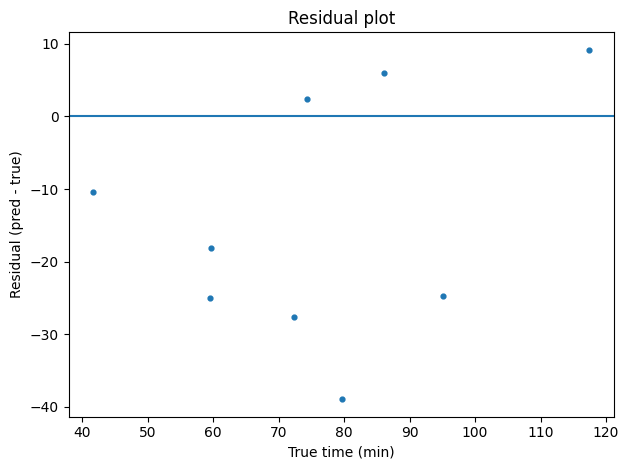

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/time_model_scaler.pkl'

In [11]:
# Optional: Tiny Neural-Net Baseline (robust to missing NumPy bridge)
from pathlib import Path
import pickle

# Safe torch import/flag so this cell won't crash if torch isn't present
try:
    import torch
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

if TORCH_AVAILABLE:
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    # --- features ---
    pairs_nn = pairs.copy()
    pairs_nn['delta_lat'] = pairs_nn['hospital_lat'] - pairs_nn['station_lat']
    pairs_nn['delta_lon'] = pairs_nn['hospital_lon'] - pairs_nn['station_lon']
    feature_cols = [
        'dist_km', 'delta_lat', 'delta_lon',
        'station_lat', 'station_lon', 'hospital_lat', 'hospital_lon'
    ]
    X = pairs_nn[feature_cols].values
    y = pairs_nn['time_min'].values

    # --- split & scale ---
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)

    # --- tensors ---
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

    # --- model ---
    model = torch.nn.Sequential(
        torch.nn.Linear(len(feature_cols), 16),
        torch.nn.ReLU(),
        torch.nn.Linear(16, 8),
        torch.nn.ReLU(),
        torch.nn.Linear(8, 1)
    )
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # --- train ---
    for epoch in range(100):
        model.train()
        optimizer.zero_grad(set_to_none=True)
        pred = model(X_train)
        loss = criterion(pred, y_train)
        loss.backward()
        optimizer.step()

    # --- eval ---
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)

    mae = torch.mean(torch.abs(val_pred - y_val)).item()
    ss_res = torch.sum((y_val - val_pred) ** 2)
    ss_tot = torch.sum((y_val - torch.mean(y_val)) ** 2)
    r2 = (1 - ss_res / ss_tot).item()
    print(f'Validation MAE: {mae:.2f} min, R^2: {r2:.2f}')

    # --- residual plot (no .numpy(); works even if PyTorch's NumPy bridge is unavailable) ---
    true_time = y_val.squeeze(1).detach().cpu().tolist()
    residuals = (val_pred - y_val).squeeze(1).detach().cpu().tolist()

    plt.figure()
    plt.scatter(true_time, residuals, s=12)
    plt.axhline(0)
    plt.xlabel('True time (min)')
    plt.ylabel('Residual (pred - true)')
    plt.title('Residual plot')
    plt.tight_layout()
    plt.show()

    # --- save artifacts ---
    scaler_path = str(Path('/mnt/data/time_model_scaler.pkl').resolve())
    model_path = str(Path('/mnt/data/time_mlp.pt').resolve())
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    torch.save(model.state_dict(), model_path)
    print('Saved:', scaler_path, model_path)

else:
    print('Skipping neural net section; torch not available.')


In [12]:
# Sanity Checks & Summary
print(f'Total nodes: {G.number_of_nodes()}')
print(f'Total edges: {G.number_of_edges()}')
print(f'Official coverage: {official/total*100:.1f}% of pairs')
print('Outputs:')
print(map_path)
print(nodes_path)
print(edges_path)
print(graphml_path)
print(assignment_path)
if TORCH_AVAILABLE:
    print(scaler_path)
    print(model_path)
print('Note: LSOA-based times approximate real routes; fallback estimates are heuristic.')

Total nodes: 18
Total edges: 45
Official coverage: 100.0% of pairs
Outputs:
/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/outputs/station_hospital_map.html
/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/nodes_station_hospital.csv
/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/edges_station_to_hospital.csv
/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/station_hospital.graphml
/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/station_best_hospital.csv
/mnt/data/time_model_scaler.pkl
/mnt/data/time_mlp.pt
Note: LSOA-based times approximate real routes; fallback estimates are heuristic.
